# **Final Project Dataset Adapter**

In this notebook, we will be working with a dataset introduced in the paper "Impact of Doppelgängers on Face Recognition: Database and Evaluation" by C. Rathgeb, P. Drozdowski, M. Obel, A. Dörsch, F. Stockhardt, N. E. Haryanto, K. Bernardo, and C. Busch, presented at the International Conference of the Biometrics Special Interest Group (BIOSIG) in Darmstadt, Germany,  September 2021.

This dataset contains images of individuals and their lookalikes, also known as doppelgängers, which are used to study the impact of doppelgängers on face recognition systems. We obtained this dataset by contacting Dr. Christian Rathgeb directly.

The primary objective of this notebook is to adapt the dataset for training a deep learning model capable of identifying doppelgängers. Specifically, we will preprocess the images to ensure they are of the same resolution, suitable for input into our model. By the end of this notebook, we will have a dataset that is ready for training our doppelgänger recognition model.

## **Imports**

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import drive
import numpy as np

#Viola Jones
import cv2 as cv
import os
from google.colab.patches import cv2_imshow

#DataLoader
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

print("OpenCV-Python Version {}".format(cv.__version__))

OpenCV-Python Version 4.8.0


In [2]:
# Load an image
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/DeepLearning_2024/FP/HDA-Doppelgaenger'

Mounted at /content/drive


## **Data Test**

To begin, we will adapt a test original image and its corresponding lookalike image by resizing them to a resolution of 256x256 pixels.

Let's first take a look at the initial images.

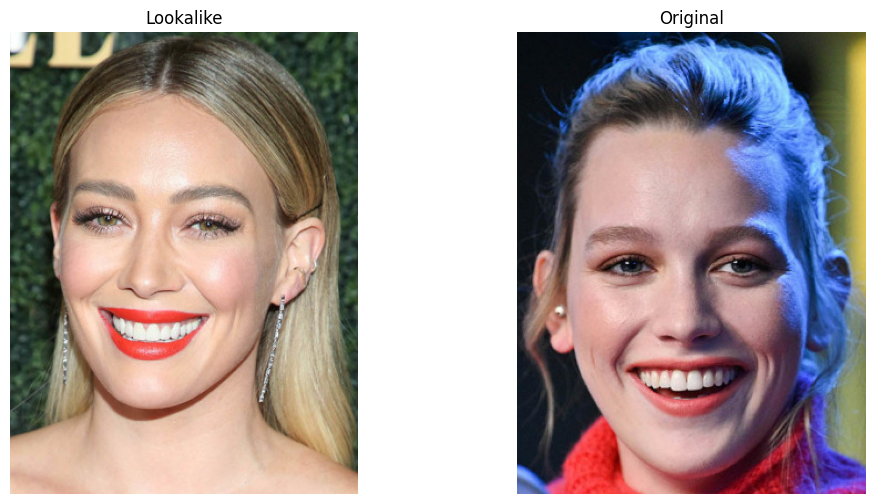

In [46]:
data_female = data_path + '/Female'
data_male = data_path + '/Male'

image_lookalike = np.array(Image.open(data_female + '/F_175_Lookalike.png'))
image_original = np.array(Image.open(data_female + '/F_175_Original.png'))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(image_lookalike)
axs[0].set_title('Lookalike')
axs[0].axis('off')

axs[1].imshow(image_original)
axs[1].set_title('Original')
axs[1].axis('off')

plt.show()

## **Viola-Jones Algorithm**

First, we will resize the images to a cropped square around the face, and then we will change the resolution.

For that, we will implement the Viola-Jones Algorithm, which detects faces in images. We will take inspiration from this website: https://realpython.com/traditional-face-detection-python/


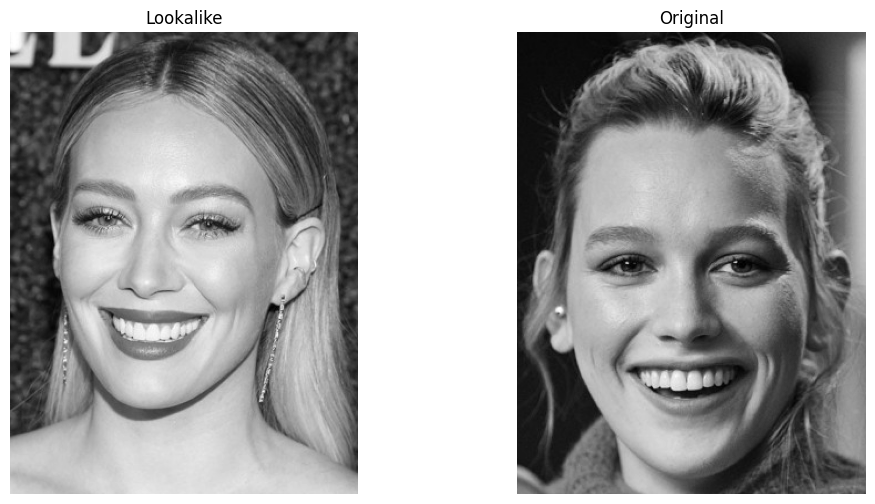

In [47]:
# Convert RGB image to Grayscale
gs_image_lookalike = cv.cvtColor(image_lookalike, cv.COLOR_RGB2GRAY)
gs_image_original = cv.cvtColor(image_original, cv.COLOR_RGB2GRAY)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(gs_image_lookalike, cmap='gray')
axs[0].set_title('Lookalike')
axs[0].axis('off')

axs[1].imshow(gs_image_original, cmap='gray')
axs[1].set_title('Original')
axs[1].axis('off')

plt.show()

In [48]:
# Get the path to the haarcascades directory
haarcascade_dir = cv.data.haarcascades
haarcascade_path = os.path.join(haarcascade_dir, 'haarcascade_frontalface_alt.xml')

# Load the classifier
face_cascade = cv.CascadeClassifier(haarcascade_path)

# Check if the classifier loaded successfully
if face_cascade.empty():
    raise IOError('Could not load face cascade classifier xml file.')
else:
    print(f'Successfully loaded face cascade classifier from {haarcascade_path}')

Successfully loaded face cascade classifier from /usr/local/lib/python3.10/dist-packages/cv2/data/haarcascade_frontalface_alt.xml


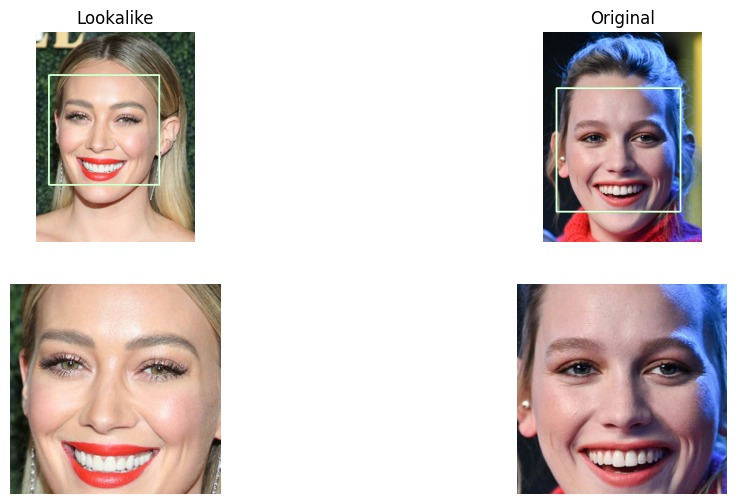

In [49]:
# Apply the classifier
detected_face_lookalike = face_cascade.detectMultiScale(gs_image_lookalike)
detected_face_original = face_cascade.detectMultiScale(gs_image_original)

# Draw a rectangle around the detected face
for (column, row, width, height) in detected_face_lookalike:
    cv.rectangle(
        image_lookalike,
        (column, row),
        (column + width, row + height),
        (0, 255, 0),
        2
    )
    # Crop the image according to the rectangle
    cropped_lookalike = image_lookalike[row+2:row+height-1, column+2:column+width-1]

for (column, row, width, height) in detected_face_original:
    cv.rectangle(
        image_original,
        (column, row),
        (column + width, row + height),
        (0, 255, 0),
        2
    )
    cropped_original = image_original[row+2:row+height-1, column+2:column+width-1]

fig, axs = plt.subplots(2, 2, figsize=(12, 6))

# Display the images with detected faces
axs[0,0].imshow(image_lookalike)
axs[0,0].set_title('Lookalike')
axs[0,0].axis('off')

axs[0,1].imshow(image_original)
axs[0,1].set_title('Original')
axs[0,1].axis('off')

# Display the cropped images
axs[1,0].imshow(cropped_lookalike)
axs[1,0].axis('off')

axs[1,1].imshow(cropped_original)
axs[1,1].axis('off')

plt.show()



Now, as we will see by checking the shapes of the two cropped images, they don't have the same resolution, so we will aply a resize function.

In [50]:
# Resize the resolution
print("Shape of Original Image", cropped_lookalike.shape)
print("Shape of Lookalike Image", cropped_original.shape)

resized_lookalike = cv.resize(cropped_lookalike, (256, 256))
resized_original = cv.resize(cropped_original, (256, 256))

print("\nShape of Resized Original Image", resized_lookalike.shape)
print("Shape of Resized Lookalike Image", resized_original.shape)


Shape of Original Image (215, 215, 4)
Shape of Lookalike Image (231, 231, 4)

Shape of Resized Original Image (256, 256, 4)
Shape of Resized Lookalike Image (256, 256, 4)


## **Data Loader**

Let's implement a Data Loader that will convert every image in the dataset and save the cropped images into new folders, which will be the ones used for training and testing.

In [26]:
class Cropper(torch.utils.data.Dataset):
    def __init__(self, data_path, transform = None):
        self.data_path = data_path
        self.transform = transform

        haarcascade_dir = cv.data.haarcascades
        haarcascade_path = os.path.join(haarcascade_dir, 'haarcascade_frontalface_alt.xml')
        self.face_cascade = cv.CascadeClassifier(haarcascade_path)

        self.file_list = []
        self.labels = []
        for label, folder in enumerate(['Female', 'Male']):
            folder_path = os.path.join(data_path, folder)
            for file_name in os.listdir(folder_path):
                self.file_list.append(os.path.join(folder_path, file_name))
                self.labels.append(label)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        label = self.labels[idx]

        # Load image
        image = Image.open(img_path).convert('RGB')

        # Convert to grayscale for face detection
        gray_image = cv.cvtColor(np.array(image), cv.COLOR_RGB2GRAY)

        # Detect face
        detected_faces = self.face_cascade.detectMultiScale(gray_image)

        if len(detected_faces) > 0:

            (column, row, width, height) = detected_faces[0]
            cropped = image.crop((column, row, column+width, row+height))

            if self.transform:
                cropped = self.transform(cropped)
            else:
                cropped = transforms.toTensor()(cropped)

            # Save cropped image to corresponding folders
            folder_name = 'Cropped'
            save_path = os.path.join(self.data_path, folder_name)
            os.makedirs(save_path, exist_ok=True)
            save_file_path = os.path.join(save_path, os.path.basename(img_path))

            if not os.path.exists(save_file_path):
                cropped_image = cropped.permute(1, 2, 0).numpy() * 255
                cropped_image = Image.fromarray(cropped_image.astype(np.uint8))
                cropped_image.save(save_file_path)

            return cropped, label

        return torch.zeros((3, 256, 256)), -1


In [27]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

face_dataset = Cropper(data_path, transform)

batch_size = 32
data_loader = torch.utils.data.DataLoader(face_dataset, batch_size=batch_size, shuffle=True)

total_batches = len(data_loader)

# Iterate over the data loader
for batch_idx, (batch_faces, batch_labels) in enumerate(data_loader):
    print(f"Iteration: {batch_idx+1}/{total_batches}")
    pass

Iteration: 1/25
Iteration: 2/25
Iteration: 3/25
Iteration: 4/25
Iteration: 5/25
Iteration: 6/25
Iteration: 7/25
Iteration: 8/25
Iteration: 9/25
Iteration: 10/25
Iteration: 11/25
Iteration: 12/25
Iteration: 13/25
Iteration: 14/25
Iteration: 15/25
Iteration: 16/25
Iteration: 17/25
Iteration: 18/25
Iteration: 19/25
Iteration: 20/25
Iteration: 21/25
Iteration: 22/25
Iteration: 23/25
Iteration: 24/25
Iteration: 25/25


## **Debugging**


We noticed that some of the files were missing (roughly 15 to 20 images) or incorrect. To mitigate that, we found which were the specific files that hadn't been saved and manually saved them.

As for the reason, we believe that the Viola Jones algorithm simply did not detect some faces at times, and depending on the execution it sometimes detects sometimes not, so going through the missing images one by one would be easier than re-running the data loader until all of them are there, as it would become difficult each time to detect how many images are missing.

The following is an example of one incorrectly detected face, which we had to manually correct.

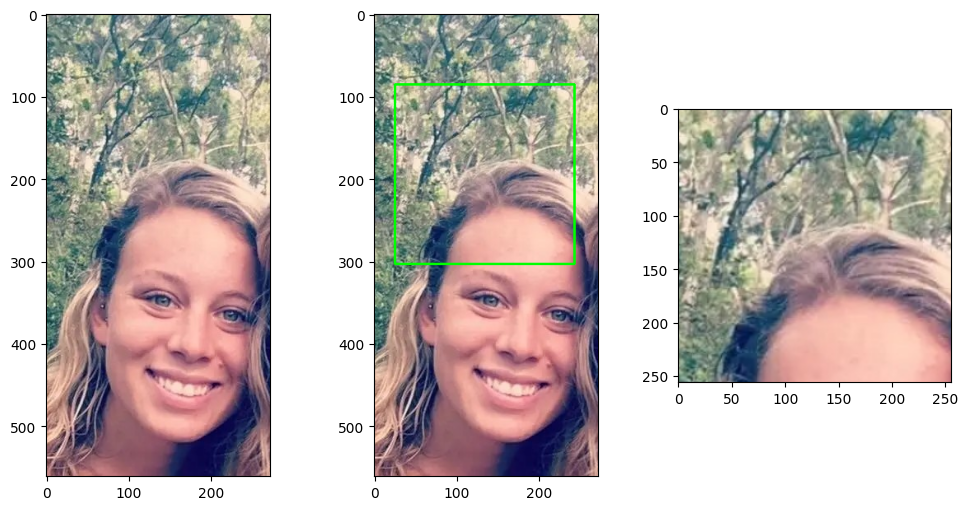

In [199]:
original = np.array(Image.open(data_female + '/F_050_Original.jpg').convert('RGB'))
rect = np.array(Image.open(data_female + '/F_050_Original.jpg').convert('RGB'))
gray = cv.cvtColor(image_lookalike, cv.COLOR_RGB2GRAY)
detect = face_cascade.detectMultiScale(gray)

for (column, row, width, height) in detected_face_lookalike:
    cv.rectangle(rect,(column, row),(column + width, row + height),(0, 255, 0),2)
    crop = original[row:row+height, column:column+width]

resized = cv.resize(crop, (256, 256))
resized = Image.fromarray(resized.astype(np.uint8))

################

fig, axs = plt.subplots(1, 3, figsize=(12, 6))
axs[0].imshow(original)
axs[1].imshow(rect)
axs[2].imshow(resized)
plt.show()

To find automatically which files were missing, instead of scanning ourselves the folder:

In [197]:
directory = data_path + '/Cropped'

# Lists to store missing files
missing_files = []

# Generate expected filenames
for gender in ['F', 'M']:
    for i in range(1, 201):
        for types in ['Lookalike', 'Original']:
            base_filename = f"{gender}_{i:03d}_{types}"
            jpg_filename = f"{base_filename}.jpg"
            png_filename = f"{base_filename}.png"
            jpeg_filename = f"{base_filename}.jpeg"

            jpg_path = os.path.join(directory, jpg_filename)
            png_path = os.path.join(directory, png_filename)
            jpeg_path = os.path.join(directory, jpeg_filename)

            if not os.path.isfile(jpg_path) and not os.path.isfile(png_path) and not os.path.isfile(jpeg_path):
                missing_files.append(base_filename)

# Output missing files
if missing_files:
    print("Missing files:\n")
    for file in missing_files:
        print(file)
else:
    print("No missing files!!")

No missing files!!


(561, 272, 3)
(256, 256, 3)


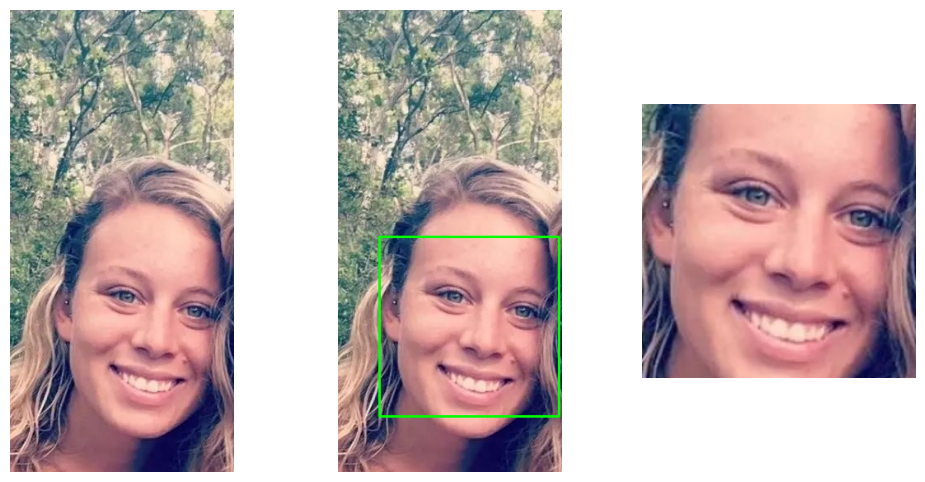

In [206]:
# TO MANUALLY ADD
image_path = '/F_050_Original.jpg'

original = np.array(Image.open(data_female + image_path).convert('RGB'))
rect = np.array(Image.open(data_female + image_path).convert('RGB'))
gray = cv.cvtColor(image_lookalike, cv.COLOR_RGB2GRAY)
detect = face_cascade.detectMultiScale(gray)

crops = []

for (column, row, width, height) in detected_face_lookalike:
    column+=25
    row+=190
    #width+=80
    #height+=80

    cv.rectangle(
        rect,
        (column, row),
        (column + width, row + height),
        (0, 255, 0),
        2
    )
    crop = original[row:row+height, column:column+width]
    crops.append(crop)
print(original.shape)

resized = cv.resize(crop, (256, 256))
print(resized.shape)

save_path = directory + image_path
resized = Image.fromarray(resized.astype(np.uint8))

################

fig, axs = plt.subplots(1, 3, figsize=(12, 6))

axs[0].imshow(original)
axs[0].axis('off')

axs[1].imshow(rect)
axs[1].axis('off')

axs[2].imshow(resized)
axs[2].axis('off')

plt.show()


#resized.save(save_path)

# dataset.mat file

In [6]:
import os
import json

In [15]:
list = sorted(os.listdir('./data'))
dataset = {
    'HDA_Doppelgaenger': []
}

for di in range(int(len(list)/2)+1, len(list)+1, 2):
    dataset['HDA_Doppelgaenger'].append([list[di], list[di-1]])

In [16]:
with open('M_dataset.json', 'w') as fp:
    json.dump(dataset, fp)